### Object Detection with Yolo

In [1]:
import swat as sw
from swat.cas.table import CASTable
from dlpy.images import ImageTable
from dlpy.applications import Tiny_Yolov2
from dlpy.utils import get_anchors
from dlpy.utils import random_name
from dlpy.utils import get_max_objects
from dlpy.utils import filter_by_filename, filter_by_image_id
from dlpy.utils import check_annotated_images
from dlpy.utils import show_images
from dlpy.splitting import two_way_split, three_way_split


#### Start CAS Server

In [2]:
s = sw.CAS('dlgrd011.unx.sas.com',  15209)

#### Load Dataset

In [3]:
modelPath='/dept/cas/weshiz'
trainSetName = "SGF_DetYolosgf416_0317_PLA.sashdat"
s.table.addcaslib(activeonadd=False,datasource={'srctype':'path'},
                  name='dnfs',path=modelPath,subdirectories=True)
s.setsessopt(caslib='dnfs')
s.table.loadtable(casout={'name':'train_set', 'replace':True, 'blocksize':350},
                  caslib='dnfs',path=trainSetName# , where=whereStr
                 )


NOTE: Cloud Analytic Services added the caslib 'dnfs'.
NOTE: 'dnfs' is now the active caslib.
NOTE: Cloud Analytic Services made the file SGF_DetYolosgf416_0317_PLA.sashdat available as table TRAIN_SET in caslib dnfs.


[caslib]

 'dnfs'

[tableName]

 'TRAIN_SET'

[casTable]

 CASTable('TRAIN_SET', caslib='dnfs')

+ Elapsed: 0.00254s, user: 0.000932s, sys: 0.000234s, mem: 0.718mb

In [5]:
train_table = s.CASTable('train_set')

### Split the Data into training and testing

In [6]:
train, test = two_way_split(train_table, stratify=False, im_table=False, train_name='train', test_name='test', seed = 42)

In [7]:
print("Training Instances : ", len(train))
print("Test Instances : ", len(test))

Training Instances :  3563
Test Instances :  891


#### Remove data points with no objects

In [8]:
train = train[~train['_nObjects_'].isNull()]
test = test[~test['_nObjects_'].isNull()]
train = train.partition(casout=dict(name='train', replace=True))['casTable']
test = test.partition(casout=dict(name='test', replace=True))['casTable']

#### View some of the images with labels

Extracting labels onto images
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib dnfs.
NOTE: Table JUST_FOR_SHOW contains compressed images.
NOTE: Cloud Analytic Services dropped table JUST_FOR_SHOW from caslib dnfs.


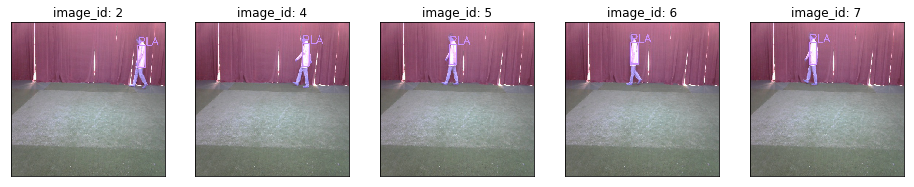

In [9]:
anotated = check_annotated_images(s, train, coord_type='yolo', nimages=5,labeled_name='Anie')

In [10]:
head = anotated.head(8)
ids = head._id_.tolist()
print(ids)

[551, 553, 554, 2198, 2199, 2200, 2201, 2202]


### Check a subset based on image_id

NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib dnfs.
Extracting labels onto images
NOTE: Cloud Analytic Services dropped table FILTERED_SGPHXE from caslib dnfs.
NOTE: Table JUST_FOR_SHOW contains compressed images.
NOTE: Cloud Analytic Services dropped table JUST_FOR_SHOW from caslib dnfs.
NOTE: Cloud Analytic Services dropped table labeled_img_tbl_JyzsU8 from caslib dnfs.


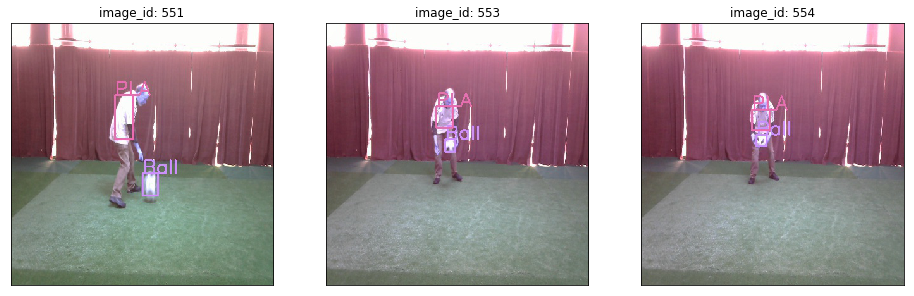

In [42]:
check_annotated_images(s, train, coord_type='yolo', return_table=False, image_id=ids[0:3])

### Build Model

In [43]:
n_anchors = 4

# use kmeans on data set to detemine what n_anchor coordinates work best
anchors = get_anchors(trainTable,'yolo', n_anchors=4)
model = Tiny_Yolov2(conn=s, randomMutation = 'random', actx = 'leaky', coordType='yolo',
            n_classes=2, predictionsPerGrid=n_anchors, width=416, height=416, 
            randomBoxes = True, softMaxForClassProb=True, matchAnchorSize=False, numToForceCoord=-1,
            rescore=True,
            classScale = 1.0, coordScale=1.0, predictionNotAObjectScale = 1, objectScale=5,
            detectionThreshold=0.2, iouThreshold = 0.1, act = 'LOGISTIC',
            anchors = anchors 
            )

NOTE: Input layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


In [45]:
model.model_name = 'Tiny_Yolov2_1'

In [46]:
model.print_summary()

*==================*===============*========*============*=================*======================*
|   Layer (Type)   |  Kernel Size  | Stride | Activation |   Output Size   | Number of Parameters |
*------------------*---------------*--------*------------*-----------------*----------------------*
| Data(Input)      |     None      |  None  |    None    |  (416, 416, 3)  |        0 / 0         |
| Conv1_1(Convo.)  |    (3, 3)     |   1    |  Identity  | (416, 416, 16)  |       432 / 0        |
| BN1_1(B.N.)      |     None      |  None  |   Leaky    | (416, 416, 16)  |       32 / 32        |
| Pool1(Pool)      |    (2, 2)     |   2    |    Max     | (208, 208, 16)  |        0 / 0         |
| Conv2_1(Convo.)  |    (3, 3)     |   1    |  Identity  | (208, 208, 32)  |       4608 / 0       |
| BN2_1(B.N.)      |     None      |  None  |   Leaky    | (208, 208, 32)  |       64 / 64        |
| Pool2(Pool)      |    (2, 2)     |   2    |    Max     | (104, 104, 32)  |        0 / 0         |


### Train Model from Scratch

In [49]:
max_objs = get_max_objects(train)
input_vars = ['_image_']
targets = ['_nObjects_'];
for i in range(0,max_objs):
    targets.append('_Object%d_'%i)
    for sp in ["x", "y", "width", "height"]:
        targets.append ('_Object%d_%s'%(i, sp))
        
optimizer=dict(miniBatchSize=64, logLevel=3, 
           maxEpochs=40, regL2=0.0005, 
           algorithm=dict(method='momentum', momentum=0.9,
                          clipGradMax=100, clipGradMin=-100,
                          learningRate=.0001,
                          lrpolicy='step', stepsize=50  ))

In [50]:
r=model.fit(data=train, optimizer=optimizer, forceEqualPadding = True, recordSeed = 13309,
      gpu = dict(devices={0, 1}),
      initWeights=None, validTable = None,
      dataspecs=[
               dict(type='IMAGE', layer='data', data=input_vars),
               dict(type='OBJECTDETECTION', layer='detect1', data=targets)
               ],
     seed=13309, nthreads=3)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 11028368.
NOTE:  The approximate memory cost is 349.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.52 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 192.
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          112.07      0.6565         0.71
NOTE:        1              192  0.0001           100.6      0.6537         0.38
NOTE:        2              192  0.0001          81.893      0.6387         0.38
NOTE:        3              192  0.0001          57.114      0.6239         0.37
NOTE:        4              192  0.0001          38.292      0.6069         0.35
NOTE:        

NOTE:       13              192  0.0001          1.6505      0.5093         0.38
NOTE:       14              192  0.0001          1.5392      0.5172         0.36
NOTE:       15              192  0.0001           1.571      0.5236         0.38
NOTE:       16              192  0.0001          1.6074      0.5071         0.36
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:          5          0.0001       1.5994      0.522         6.62
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          1.6346      0.5183         0.69
NOTE:        1              192  0.0001          1.5179      0.5218         0.41
NOTE:        2              192  0.0001          1.5079      0.5106         0.37
NOTE:        3              192  0.0001          1.5808      0.5082         0.40
NOTE:        4              192  0.0001          1.5394      0.5273         0.39
NOTE:        5              192  

NOTE:        1              192  0.0001          1.3499      0.4851         0.37
NOTE:        2              192  0.0001          1.4356       0.506         0.38
NOTE:        3              192  0.0001          1.3549      0.4877         0.37
NOTE:        4              192  0.0001          1.3506      0.5005         0.39
NOTE:        5              192  0.0001          1.3987      0.4941         0.37
NOTE:        6              192  0.0001           1.348      0.4927         0.39
NOTE:        7              192  0.0001          1.3871      0.4848         0.40
NOTE:        8              192  0.0001          1.3707       0.493         0.35
NOTE:        9              192  0.0001          1.3905      0.4864         0.39
NOTE:       10              192  0.0001          1.3409      0.4862         0.38
NOTE:       11              192  0.0001           1.347      0.4881         0.36
NOTE:       12              192  0.0001          1.3561      0.5002         0.35
NOTE:       13              

NOTE:        1              192  0.0001          1.1658      0.4893         0.38
NOTE:        2              192  0.0001          1.3154      0.4773         0.39
NOTE:        3              192  0.0001          1.2144      0.4757         0.39
NOTE:        4              192  0.0001          1.3486      0.4687         0.38
NOTE:        5              192  0.0001          1.1919      0.4683         0.36
NOTE:        6              192  0.0001          1.2669      0.4438         0.38
NOTE:        7              192  0.0001          1.2842      0.4632         0.38
NOTE:        8              192  0.0001          1.2921      0.4735         0.37
NOTE:        9              192  0.0001          1.2398      0.4829         0.37
NOTE:       10              192  0.0001          1.2235      0.4748         0.35
NOTE:       11              192  0.0001          1.2081      0.4465         0.39
NOTE:       12              192  0.0001            1.31      0.4705         0.36
NOTE:       13              

NOTE:        8              192  0.0001          1.1459      0.4733         0.37
NOTE:        9              192  0.0001          1.2375      0.4663         0.38
NOTE:       10              192  0.0001          1.1981       0.453         0.39
NOTE:       11              192  0.0001          1.0589      0.4672         0.36
NOTE:       12              192  0.0001          1.1794      0.4732         0.39
NOTE:       13              192  0.0001          1.1712      0.4457         0.37
NOTE:       14              192  0.0001          1.1822      0.4723         0.38
NOTE:       15              192  0.0001          1.0905      0.4569         0.39
NOTE:       16              192  0.0001          1.1025      0.4624         0.40
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         22          0.0001       1.1472      0.461         6.74
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  

NOTE:        6              192  0.0001          1.0587      0.4389         0.40
NOTE:        7              192  0.0001          1.0033      0.4324         0.40
NOTE:        8              192  0.0001          1.1043       0.431         0.38
NOTE:        9              192  0.0001           1.022       0.437         0.39
NOTE:       10              192  0.0001          1.1047      0.4422         0.38
NOTE:       11              192  0.0001          1.1272        0.45         0.37
NOTE:       12              192  0.0001          1.0102      0.4528         0.36
NOTE:       13              192  0.0001          1.0709      0.4425         0.38
NOTE:       14              192  0.0001          1.0706      0.4415         0.36
NOTE:       15              192  0.0001          1.0708      0.4455         0.39
NOTE:       16              192  0.0001          1.2236      0.4422         0.35
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         28          0.0001    

NOTE:       15              192  0.0001          0.9919       0.446         0.36
NOTE:       16              192  0.0001          1.0996      0.4159         0.38
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         35          0.0001       1.0367     0.4317         6.67
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          0.9611       0.422         0.69
NOTE:        1              192  0.0001          1.0162      0.4296         0.43
NOTE:        2              192  0.0001          1.0045      0.4348         0.37
NOTE:        3              192  0.0001          0.8918      0.4257         0.37
NOTE:        4              192  0.0001           1.034      0.4338         0.36
NOTE:        5              192  0.0001          0.9409      0.4188         0.38
NOTE:        6              192  0.0001          1.0452       0.432         0.36
NOTE:        7              192  

### Score the model on the test set

In [52]:
s.dlscore(model=model.model_table, randommutation='none',
    initWeights=model.model_weights, 
    table = test,
    copyVars=['_path_', '_id_', '_image_'],  
    nThreads=3,
    gpu=1,
    loglevel=1,
    casout={'name':'detections', 'replace':True}
)

NOTE:  Loading weights cost       0.10 (s).
NOTE:  Initializing each layer cost       2.79 (s).


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           790
 1  Number of Observations Used           790
 2            Average IOU Error      0.408641
 3                   Loss Error      0.888153

[OutputCasTables]

   casLib        Name  Rows  Columns                               casTable
 0   dnfs  detections   790     4060  CASTable('detections', caslib='dnfs')

+ Elapsed: 4.99s, user: 5.12s, sys: 1.68s, mem: 291mb

In [53]:
detections = s.CASTable('detections')

Extracting labels onto images
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib dnfs.
NOTE: Cloud Analytic Services dropped table JUST_FOR_SHOW from caslib dnfs.


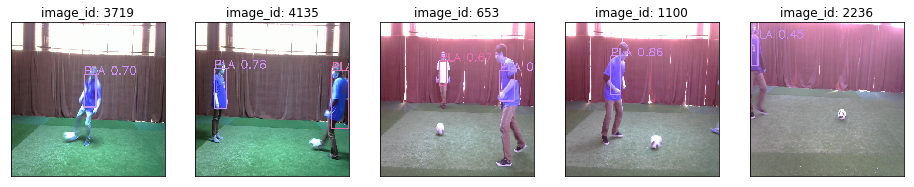

In [54]:
predictions = check_annotated_images(s,detections, coord_type='yolo',labeled_name='predictions', randomize=True)

We see that after only 40 epochs the model predictions are not bad.
The Average IOU Error was 0.336513. 
Lets save and reload the model and continue training with a lower learning rate.

### Save Model

In [55]:
model.deploy(path='/cas/DeepLearn/adstev/pre_trained', output_format='table')

NOTE: Model table saved successfully.


### Reload Model

In [65]:
model_file = '/cas/DeepLearn/adstev/pre_trained/Tiny_Yolov2_1.sashdat'
from dlpy import Model
model = Model(s)
model.load(path=model_file)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "tiny-yolov2" according to the model name in the table.
NOTE: Tiny_Yolov2_1_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: Tiny_Yolov2_1_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


### Reduce Learning Rate and Continue Training

In [66]:
max_objs = get_max_objects(train)
input_vars = ['_image_']
targets = ['_nObjects_'];
for i in range(0,max_objs):
    targets.append('_Object%d_'%i)
    for sp in ["x", "y", "width", "height"]:
        targets.append ('_Object%d_%s'%(i, sp))
        
optimizer=dict(miniBatchSize=64, logLevel=3, 
           maxEpochs=40, regL2=0.0005, 
           algorithm=dict(method='momentum', momentum=0.9,
                          clipGradMax=100, clipGradMin=-100,
                          learningRate=.00005,
                          lrpolicy='step', stepsize=50  ))

In [67]:
r=model.fit(data=train, optimizer=optimizer, forceEqualPadding = True, recordSeed = 13309,
      gpu = dict(devices={0,1}),
      initWeights=model.model_weights, validTable = None,
      dataspecs=[
               dict(type='IMAGE', layer='data', data=input_vars),
               dict(type='OBJECTDETECTION', layer='detect1', data=targets)
               ],
     seed=13309, nthreads=3)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 11028368.
NOTE:  The approximate memory cost is 349.00 MB.
NOTE:  Loading weights cost       0.43 (s).
NOTE:  Initializing each layer cost       2.67 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 192.
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          1.0102      0.4192         0.70
NOTE:        1              192    5E-5          1.0963      0.4166         0.39
NOTE:        2              192    5E-5          1.0689      0.4166         0.41
NOTE:        3              192    5E-5          0.9056      0.4219         0.38
NOTE:        4              192    5E-5          1.0307      0.4131         0.38
NOTE:        

NOTE:       14              192    5E-5          0.9897       0.429         0.35
NOTE:       15              192    5E-5          0.9932      0.4146         0.34
NOTE:       16              192    5E-5           1.005      0.4155         0.36
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:          4            5E-5       0.9803     0.4132         6.87
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.9466       0.433         0.67
NOTE:        1              192    5E-5          0.9284      0.4229         0.36
NOTE:        2              192    5E-5          0.9345       0.406         0.39
NOTE:        3              192    5E-5          0.9833      0.4012         0.36
NOTE:        4              192    5E-5          0.9633      0.3865         0.36
NOTE:        5              192    5E-5          1.0106      0.4128         0.37
NOTE:        6              192  

NOTE:       10              192    5E-5          0.8971      0.4046         0.36
NOTE:       11              192    5E-5          0.8765      0.4075         0.36
NOTE:       12              192    5E-5          0.9192      0.4294         0.35
NOTE:       13              192    5E-5          0.9207      0.3969         0.39
NOTE:       14              192    5E-5          1.0472      0.4102         0.38
NOTE:       15              192    5E-5           0.958      0.4016         0.39
NOTE:       16              192    5E-5          1.0083      0.4216         0.38
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         11            5E-5       0.9559     0.4093         6.71
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.8903      0.4104         0.69
NOTE:        1              192    5E-5          0.9311      0.3929         0.39
NOTE:        2              192  

NOTE:       15              192    5E-5          0.8659      0.3953         0.37
NOTE:       16              192    5E-5          0.8846      0.4079         0.37
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         16            5E-5       0.9124     0.4064         6.90
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.8887       0.411         0.70
NOTE:        1              192    5E-5          0.8794      0.4147         0.40
NOTE:        2              192    5E-5          0.9709      0.4105         0.41
NOTE:        3              192    5E-5          0.9205      0.4064         0.40
NOTE:        4              192    5E-5          0.9696      0.4074         0.39
NOTE:        5              192    5E-5          0.8646      0.4037         0.39
NOTE:        6              192    5E-5          0.9039      0.3877         0.41
NOTE:        7              192  

NOTE:       11              192    5E-5          0.8063      0.4104         0.37
NOTE:       12              192    5E-5          0.8815       0.422         0.37
NOTE:       13              192    5E-5          0.9177      0.3975         0.37
NOTE:       14              192    5E-5          0.8788      0.4222         0.38
NOTE:       15              192    5E-5          0.7942      0.4062         0.38
NOTE:       16              192    5E-5          0.8461       0.403         0.43
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         22            5E-5       0.8701      0.405         6.66
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5           0.943      0.4047         0.70
NOTE:        1              192    5E-5          0.8735      0.3997         0.40
NOTE:        2              192    5E-5           0.888      0.3997         0.38
NOTE:        3              192  

NOTE:        7              192    5E-5          0.7842      0.3915         0.37
NOTE:        8              192    5E-5           0.818       0.389         0.37
NOTE:        9              192    5E-5          0.8113       0.387         0.39
NOTE:       10              192    5E-5          0.8573      0.4008         0.38
NOTE:       11              192    5E-5          0.9078      0.4062         0.39
NOTE:       12              192    5E-5          0.7927      0.4066         0.37
NOTE:       13              192    5E-5          0.8098      0.4011         0.38
NOTE:       14              192    5E-5          0.8234      0.4023         0.36
NOTE:       15              192    5E-5           0.848      0.4019         0.38
NOTE:       16              192    5E-5          0.9341      0.4011         0.36
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         28            5E-5       0.8475     0.4002         6.72
NOTE:  Batch              nUsed   Learning Rate

NOTE:        7              192    5E-5          0.8667      0.3944         0.38
NOTE:        8              192    5E-5          0.9124      0.3988         0.37
NOTE:        9              192    5E-5          0.8092      0.3951         0.39
NOTE:       10              192    5E-5          0.8179      0.3949         0.36
NOTE:       11              192    5E-5          0.8557      0.4144         0.40
NOTE:       12              192    5E-5          0.8401      0.4009         0.40
NOTE:       13              192    5E-5          0.8006      0.3781         0.39
NOTE:       14              192    5E-5          0.8987       0.395         0.35
NOTE:       15              192    5E-5          0.8396      0.4184         0.37
NOTE:       16              192    5E-5          0.8888      0.3827         0.39
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         35            5E-5       0.8422     0.3974         6.76
NOTE:  Batch              nUsed   Learning Rate

In [68]:
s.dlscore(model=model.model_table, randommutation='none',
    initWeights=model.model_weights, 
    table = test,
    copyVars=['_path_', '_id_', '_image_'],  
    nThreads=3,
    gpu=1,
    loglevel=1,
    casout={'name':'detections', 'replace':True}
)

NOTE:  Loading weights cost       0.09 (s).
NOTE:  Initializing each layer cost       2.44 (s).


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           790
 1  Number of Observations Used           790
 2            Average IOU Error      0.379281
 3                   Loss Error      0.708109

[OutputCasTables]

   casLib        Name  Rows  Columns                               casTable
 0   dnfs  detections   790     4060  CASTable('detections', caslib='dnfs')

+ Elapsed: 4.66s, user: 5.15s, sys: 1.29s, mem: 292mb

The Average IOU Error has dropped from 0.408641 to 0.379281 after reducing the learning rate and training for 40 more epochs.

In [69]:
detections = s.CASTable('detections')

Extracting labels onto images
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib dnfs.
NOTE: Cloud Analytic Services dropped table JUST_FOR_SHOW from caslib dnfs.


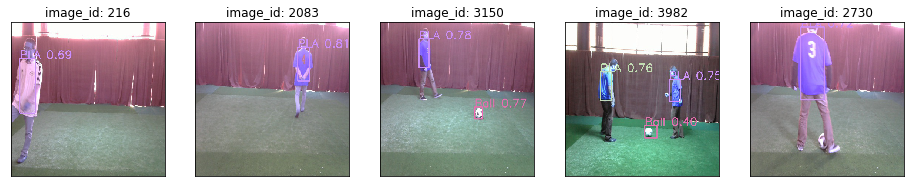

In [70]:
predictions = check_annotated_images(s,detections, coord_type='yolo',labeled_name='predictions', randomize=True)

#### Change name and save updated model

In [72]:
model.model_name = 'Tiny_Yolov2_2'

In [73]:
model.deploy(path='/cas/DeepLearn/adstev/pre_trained', output_format='table')

NOTE: Model table saved successfully.


### Now try with a model pretrained on another Imagenet

In [83]:
model_pre = Tiny_Yolov2(conn=s, model_table='Tiny-Yolov2-pre', randomMutation = 'random', actx = 'leaky', coordType='yolo',
            n_classes=2, predictionsPerGrid=n_anchors, width=416, height=416, 
            randomBoxes = True, softMaxForClassProb=True, matchAnchorSize=False, numToForceCoord=-1,
            rescore=True,
            classScale = 1.0, coordScale=1.0, predictionNotAObjectScale = 1, objectScale=5,
            detectionThreshold=0.2, iouThreshold = 0.1, act = 'LOGISTIC',
            anchors = anchors 
            )

NOTE: Input layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


In [75]:
s.table.loadtable(casout={'name':'Darknet_Reference_weights','replace':True}, caslib='dnfs',path="DL_MODELS/Darknet_Reference_weights2.sashdat");
s.table.loadtable(casout={'replace':True}, caslib='dnfs',path='DL_MODELS/Darknet_Reference_weights_attr2.sashdat');
s.table.attribute(name='Darknet_Reference_weights',table='DL_MODELS.DARKNET_REFERENCE_WEIGHTS_ATTR2');

NOTE: Cloud Analytic Services made the file DL_MODELS/Darknet_Reference_weights2.sashdat available as table DARKNET_REFERENCE_WEIGHTS in caslib dnfs.
NOTE: Cloud Analytic Services made the file DL_MODELS/Darknet_Reference_weights_attr2.sashdat available as table DL_MODELS.DARKNET_REFERENCE_WEIGHTS_ATTR2 in caslib dnfs.


In model_pre.fit initWeights is set to 'Darknet_Reference_weights'

In [84]:
optimizer=dict(miniBatchSize=64, logLevel=3, 
               maxEpochs=40, regL2=0.0005, 
               algorithm=dict(method='momentum', momentum=0.9,
                              clipGradMax=100, clipGradMin=-100,
                              learningRate=0.0001,
                              lrpolicy='step', stepsize=50
                             )
              )
r=model_pre.fit(data=train, optimizer=optimizer, forceEqualPadding = True, recordSeed = 13309,
          gpu = dict(devices={0,1}),
            initWeights=dict(name = 'Darknet_Reference_weights',where='_layerid_<21'),
            dataspecs=[dict(type='IMAGE', layer='data', data=['_image_']),
                       dict(type='OBJECTDETECTION', layer='detect1', data=targets)
                      ],
                seed=13309, nthreads=3)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 11028368.
NOTE:  The approximate memory cost is 349.00 MB.
NOTE:  Loading weights cost       0.79 (s).
NOTE:  Initializing each layer cost       2.62 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 192.
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          85.751      0.6921         0.68
NOTE:        1              192  0.0001          76.819      0.6882         0.38
NOTE:        2              192  0.0001          62.408      0.6727         0.36
NOTE:        3              192  0.0001          43.628      0.6602         0.36
NOTE:        4              192  0.0001          29.887       0.672         0.36
NOTE:        

NOTE:       13              192  0.0001          1.3022      0.5061         0.37
NOTE:       14              192  0.0001          1.2803      0.5044         0.37
NOTE:       15              192  0.0001           1.296      0.5154         0.34
NOTE:       16              192  0.0001          1.2978      0.4971         0.37
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:          4          0.0001       1.3595     0.5045         6.73
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          1.2568      0.5047         0.67
NOTE:        1              192  0.0001          1.2809      0.4935         0.37
NOTE:        2              192  0.0001          1.2301      0.4875         0.40
NOTE:        3              192  0.0001          1.3098      0.4748         0.37
NOTE:        4              192  0.0001          1.2529      0.4866         0.39
NOTE:        5              192  

NOTE:       11              192  0.0001          0.8049      0.4225         0.37
NOTE:       12              192  0.0001           0.841      0.4214         0.36
NOTE:       13              192  0.0001          0.8489      0.4293         0.41
NOTE:       14              192  0.0001          0.8203      0.4205         0.37
NOTE:       15              192  0.0001          0.7862      0.4245         0.37
NOTE:       16              192  0.0001          0.8382      0.4069         0.37
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         10          0.0001         0.85     0.4238         6.65
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          0.8428      0.4139         0.68
NOTE:        1              192  0.0001          0.7844      0.4142         0.37
NOTE:        2              192  0.0001          0.8935      0.4238         0.39
NOTE:        3              192  

NOTE:       12              192  0.0001          0.6538      0.3858         0.38
NOTE:       13              192  0.0001          0.5802      0.3683         0.38
NOTE:       14              192  0.0001          0.6209      0.3853         0.37
NOTE:       15              192  0.0001          0.5827      0.3599         0.38
NOTE:       16              192  0.0001          0.6777      0.3706         0.35
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         16          0.0001       0.6599     0.3767         6.72
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  0.0001          0.6259      0.3848         0.68
NOTE:        1              192  0.0001          0.5623      0.3777         0.38
NOTE:        2              192  0.0001          0.6804      0.3859         0.39
NOTE:        3              192  0.0001           0.617      0.3774         0.43
NOTE:        4              192  

NOTE:        1              192  0.0001          0.5308      0.3531         0.37
NOTE:        2              192  0.0001          0.5507      0.3645         0.37
NOTE:        3              192  0.0001          0.5059      0.3416         0.41
NOTE:        4              192  0.0001          0.5577      0.3548         0.38
NOTE:        5              192  0.0001          0.5784        0.36         0.39
NOTE:        6              192  0.0001          0.5058       0.336         0.36
NOTE:        7              192  0.0001          0.5305      0.3445         0.38
NOTE:        8              192  0.0001          0.4973      0.3463         0.39
NOTE:        9              192  0.0001            0.63      0.3563         0.39
NOTE:       10              192  0.0001          0.6323      0.3531         0.39
NOTE:       11              192  0.0001          0.4968      0.3565         0.38
NOTE:       12              192  0.0001          0.5002      0.3548         0.40
NOTE:       13              

NOTE:        8              192  0.0001          0.4248      0.3264         0.37
NOTE:        9              192  0.0001          0.4935      0.3116         0.39
NOTE:       10              192  0.0001          0.4581      0.3377         0.38
NOTE:       11              192  0.0001          0.4842      0.3375         0.37
NOTE:       12              192  0.0001          0.4311      0.3323         0.36
NOTE:       13              192  0.0001           0.468      0.3286         0.38
NOTE:       14              192  0.0001          0.4949      0.3333         0.36
NOTE:       15              192  0.0001          0.4715       0.309         0.38
NOTE:       16              192  0.0001          0.5146       0.324         0.36
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         28          0.0001       0.4836     0.3296         6.67
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192  

NOTE:        2              192  0.0001          0.4154      0.3069         0.38
NOTE:        3              192  0.0001          0.3998      0.3163         0.38
NOTE:        4              192  0.0001          0.4656      0.3298         0.41
NOTE:        5              192  0.0001          0.4024      0.3159         0.40
NOTE:        6              192  0.0001          0.4282       0.319         0.38
NOTE:        7              192  0.0001          0.5268      0.3197         0.39
NOTE:        8              192  0.0001          0.4865      0.3137         0.36
NOTE:        9              192  0.0001          0.4044      0.3116         0.37
NOTE:       10              192  0.0001          0.4178      0.3082         0.36
NOTE:       11              192  0.0001          0.4574      0.3244         0.42
NOTE:       12              192  0.0001          0.4334      0.3112         0.38
NOTE:       13              192  0.0001          0.4597      0.3149         0.39
NOTE:       14              

In [85]:
s.dlscore(model=model_pre.model_table, randommutation='none',
    initWeights=model_pre.model_weights, 
    table = test,
    copyVars=['_path_', '_id_', '_image_'],  
    nThreads=3,
    gpu=1,
    loglevel=1,
    casout={'name':'detections', 'replace':True}
)

NOTE:  Loading weights cost       0.10 (s).
NOTE:  Initializing each layer cost       2.44 (s).


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           790
 1  Number of Observations Used           790
 2            Average IOU Error      0.318346
 3                   Loss Error      0.441882

[OutputCasTables]

   casLib        Name  Rows  Columns                               casTable
 0   dnfs  detections   790     4060  CASTable('detections', caslib='dnfs')

+ Elapsed: 4.56s, user: 5.17s, sys: 1.23s, mem: 291mb

#### Using a pretrained model we see the Average IoU error after 40 epochs is .318 which is lower than when trained from scratch

### Continue training using reduced learning rate

In [86]:
optimizer=dict(miniBatchSize=64, logLevel=3, 
               maxEpochs=40, regL2=0.0005, 
               algorithm=dict(method='momentum', momentum=0.9,
                              clipGradMax=100, clipGradMin=-100,
                              learningRate=0.00005,
                              lrpolicy='step', stepsize=50
                             )
              )
r=model_pre.fit(data=train, optimizer=optimizer, forceEqualPadding = True, recordSeed = 13309,
          gpu = dict(devices={0,1}),
            initWeights=model_pre.model_weights,
            dataspecs=[dict(type='IMAGE', layer='data', data=['_image_']),
                       dict(type='OBJECTDETECTION', layer='detect1', data=targets)
                      ],
                seed=13309, nthreads=3)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 11028368.
NOTE:  The approximate memory cost is 349.00 MB.
NOTE:  Loading weights cost       0.10 (s).
NOTE:  Initializing each layer cost       2.84 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 192.
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.3894      0.2964         0.70
NOTE:        1              192    5E-5          0.4592      0.3083         0.37
NOTE:        2              192    5E-5          0.3658        0.31         0.39
NOTE:        3              192    5E-5          0.3754      0.3065         0.38
NOTE:        4              192    5E-5          0.3765      0.2983         0.38
NOTE:        

NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.3914      0.3169         0.67
NOTE:        1              192    5E-5          0.3785      0.2931         0.39
NOTE:        2              192    5E-5          0.3506      0.2921         0.39
NOTE:        3              192    5E-5          0.3683      0.2908         0.37
NOTE:        4              192    5E-5          0.3555      0.2835         0.37
NOTE:        5              192    5E-5          0.3938      0.3023         0.37
NOTE:        6              192    5E-5          0.3916       0.279         0.38
NOTE:        7              192    5E-5           0.374      0.2964         0.36
NOTE:        8              192    5E-5          0.4162      0.3123         0.40
NOTE:        9              192    5E-5          0.4317      0.2914         0.42
NOTE:       10              192    5E-5          0.3851      0.2981         0.41
NOTE:       11

NOTE:        3              192    5E-5          0.3182      0.2841         0.36
NOTE:        4              192    5E-5          0.3573      0.2966         0.37
NOTE:        5              192    5E-5          0.4017        0.29         0.37
NOTE:        6              192    5E-5          0.4041      0.2895         0.38
NOTE:        7              192    5E-5          0.3368      0.2974         0.39
NOTE:        8              192    5E-5          0.3633      0.2917         0.36
NOTE:        9              192    5E-5          0.3681      0.2938         0.38
NOTE:       10              192    5E-5          0.3678      0.2869         0.37
NOTE:       11              192    5E-5          0.3266      0.3013         0.35
NOTE:       12              192    5E-5          0.3622      0.2976         0.35
NOTE:       13              192    5E-5          0.3353      0.2907         0.39
NOTE:       14              192    5E-5          0.3747       0.299         0.37
NOTE:       15              

NOTE:       16              192    5E-5          0.3239      0.2861         0.35
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         17            5E-5       0.3492     0.2873         6.65
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.3303      0.3083         0.68
NOTE:        1              192    5E-5          0.3225      0.2895         0.35
NOTE:        2              192    5E-5          0.3244      0.2833         0.37
NOTE:        3              192    5E-5          0.2991      0.2868         0.37
NOTE:        4              192    5E-5           0.306      0.2848         0.37
NOTE:        5              192    5E-5            0.38      0.2877         0.37
NOTE:        6              192    5E-5          0.4148      0.2975         0.37
NOTE:        7              192    5E-5          0.3604      0.2796         0.36
NOTE:        8              192  

NOTE:       13              192    5E-5          0.3443       0.275         0.37
NOTE:       14              192    5E-5          0.3383        0.28         0.41
NOTE:       15              192    5E-5          0.3324      0.2858         0.36
NOTE:       16              192    5E-5          0.3411      0.2924         0.37
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         23            5E-5       0.3345     0.2868         6.96
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5           0.289      0.2645         0.68
NOTE:        1              192    5E-5          0.3428      0.2984         0.41
NOTE:        2              192    5E-5          0.3334      0.2789         0.39
NOTE:        3              192    5E-5           0.381      0.2995         0.38
NOTE:        4              192    5E-5          0.3072      0.2843         0.36
NOTE:        5              192  

NOTE:       11              192    5E-5          0.3316      0.2751         0.35
NOTE:       12              192    5E-5          0.3182      0.2924         0.36
NOTE:       13              192    5E-5           0.337      0.2859         0.38
NOTE:       14              192    5E-5          0.3133      0.2816         0.37
NOTE:       15              192    5E-5          0.3321      0.2836         0.39
NOTE:       16              192    5E-5          0.3283       0.288         0.37
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         30            5E-5       0.3283     0.2826         6.57
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0              192    5E-5          0.3392      0.2817         0.69
NOTE:        1              192    5E-5          0.3363      0.2861         0.38
NOTE:        2              192    5E-5          0.2857      0.2765         0.39
NOTE:        3              192  

NOTE:        0              192    5E-5           0.289      0.2787         0.70
NOTE:        1              192    5E-5          0.3045      0.2778         0.39
NOTE:        2              192    5E-5           0.301      0.2737         0.36
NOTE:        3              192    5E-5          0.2803      0.2752         0.38
NOTE:        4              192    5E-5           0.323      0.2812         0.38
NOTE:        5              192    5E-5          0.2956      0.2689         0.38
NOTE:        6              192    5E-5          0.3435      0.2656         0.36
NOTE:        7              192    5E-5          0.3141      0.2843         0.39
NOTE:        8              192    5E-5          0.3154      0.2755         0.37
NOTE:        9              192    5E-5           0.275      0.2777         0.39
NOTE:       10              192    5E-5          0.3378      0.2832         0.36
NOTE:       11              192    5E-5          0.3122      0.2844         0.38
NOTE:       12              

In [87]:
s.dlscore(model=model_pre.model_table, randommutation='none',
    initWeights=model_pre.model_weights, 
    table = test,
    copyVars=['_path_', '_id_', '_image_'],  
    nThreads=3,
    gpu=1,
    loglevel=1,
    casout={'name':'detections', 'replace':True}
)

NOTE:  Loading weights cost       0.10 (s).
NOTE:  Initializing each layer cost       2.38 (s).


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           790
 1  Number of Observations Used           790
 2            Average IOU Error      0.301431
 3                   Loss Error      0.397363

[OutputCasTables]

   casLib        Name  Rows  Columns                               casTable
 0   dnfs  detections   790     4060  CASTable('detections', caslib='dnfs')

+ Elapsed: 4.48s, user: 5.11s, sys: 1.27s, mem: 291mb

The IOU loss has only dropped slightly after reducing the learning rate and training for 40 more epochs.

In [88]:
detections = s.CASTable('detections')

Extracting labels onto images
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib dnfs.
NOTE: Cloud Analytic Services dropped table JUST_FOR_SHOW from caslib dnfs.


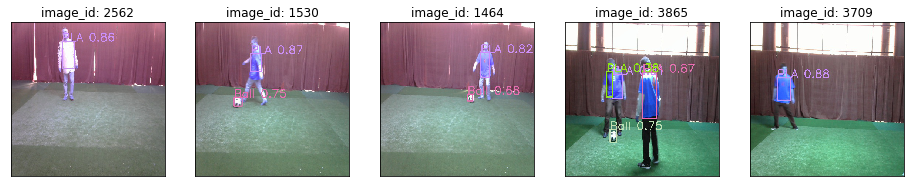

In [89]:
predictions = check_annotated_images(s,detections, coord_type='yolo',labeled_name='predictions', randomize=True)

### Save final model

In [90]:
model_pre.deploy(path='/cas/DeepLearn/adstev/pre_trained', output_format='table')

NOTE: Model table saved successfully.
